In [1]:
# ================================
# 1. Import Libraries
# ================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# ================================
# 2. Load & Data
# ================================
# Replace 'stellar.csv' with your dataset path
df = pd.read_csv("D:\Praveer MTech\Course\Assignment\ML\Assignment 2\star_classification.csv")

In [2]:
#Clean the data
# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values (simple strategy: drop rows with NA)
df.dropna(inplace=True)

# Drop irrelevant identifiers (unique IDs that don’t help classification)
id_columns = ["run_ID", "rerun_ID", "cam_col", "field_ID",
              "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df.drop(columns=id_columns, inplace=True)


In [3]:
#Pre-processing
# Encode target labels
label_enc = LabelEncoder()
df["class"] = label_enc.fit_transform(df["class"])  # galaxy=0, star=1, quasar=2 (example)

X = df.drop(columns=["class"])
y = df["class"]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k="all")
X_selected = selector.fit_transform(X_scaled, y)

# Show feature importance scores
feature_scores = pd.DataFrame({
    "Feature": X.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

print("Feature importance ranking:\n", feature_scores)

Feature importance ranking:
     Feature         Score
8  redshift  83429.418967
6         i   8282.343545
5         r   4584.533364
2     delta    217.588357
0    obj_ID    122.542455
7         z     32.328308
3         u     30.445339
4         g     25.962524
1     alpha     21.948822


In [4]:
#Train / Test data split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Example: choose one model by name
selected_model_name = "Logistic Regression"   # <-- change this to your choice

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Train only the selected model
model = models[selected_model_name]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [6]:
# Metrics calculation.
try:
    y_prob = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
except:
    auc = None

print(f"\n===== {selected_model_name} =====")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
if auc is not None:
    print(f"AUC      : {auc:.4f}")
else:
    print("AUC      : Not available")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"MCC      : {matthews_corrcoef(y_test, y_pred):.4f}")


===== Logistic Regression =====
Accuracy : 0.9284
AUC      : 0.9777
Precision: 0.9294
Recall   : 0.9284
F1 Score : 0.9278
MCC      : 0.8719


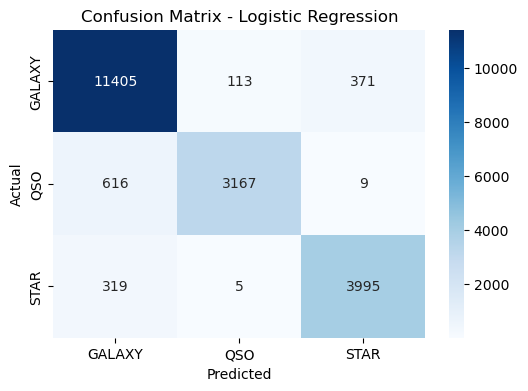

In [7]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {selected_model_name}")
plt.show()


In [8]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))



Classification Report:

              precision    recall  f1-score   support

      GALAXY       0.92      0.96      0.94     11889
         QSO       0.96      0.84      0.90      3792
        STAR       0.91      0.92      0.92      4319

    accuracy                           0.93     20000
   macro avg       0.93      0.91      0.92     20000
weighted avg       0.93      0.93      0.93     20000

